In [3]:
#This dataframes need to be collected in one for precise prediction, so this is what we will do first!
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [4]:
#import dataframes
data_train = pd.read_csv('C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting/train.csv')
data_test = pd.read_csv('C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting/test.csv')
data_holiday = pd.read_csv('C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting/holidays_events.csv')
data_oil = pd.read_csv('C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting/oil.csv')
data_sub = pd.read_csv('C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting/sample_submission.csv')
data_stores = pd.read_csv('C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting/stores.csv')
data_trans = pd.read_csv('C:/Users/pc/Desktop/projet_class/Python_project/store-sales-time-series-forecasting/transactions.csv')

In [5]:
## combine datasets
data_train1 = data_train.merge(data_oil, on = 'date', how='left')
data_train1 = data_train1.merge(data_holiday, on = 'date', how='left')
data_train1 = data_train1.merge(data_stores, on = 'store_nbr', how='left')
data_train1 = data_train1.merge(data_trans, on = ['date', 'store_nbr'], how='left')
data_train1 = data_train1.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})

data_test1 = data_test.merge(data_oil, on = 'date', how='left')
data_test1 = data_test1.merge(data_holiday, on = 'date', how='left')
data_test1 = data_test1.merge(data_stores, on = 'store_nbr', how='left')
data_test1 = data_test1.merge(data_trans, on = ['date', 'store_nbr'], how='left')
data_test1 = data_test1.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})

In [6]:
data_train1.duplicated()

0          False
1          False
2          False
3          False
4          False
           ...  
3054343    False
3054344    False
3054345    False
3054346    False
3054347    False
Length: 3054348, dtype: bool

In [7]:
data_test1.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
28507    False
28508    False
28509    False
28510    False
28511    False
Length: 28512, dtype: bool

In [8]:
data_train1.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred,city,state,store_type,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN


In [9]:
def create_ts_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    return df

In [10]:
data_train1 = create_ts_features(data_train1)
data_test1 = create_ts_features(data_test1)
data_train1.head(3)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,...,state,store_type,cluster,transactions,dayofweek,quarter,month,year,dayofyear,dayofmonth
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,...,Pichincha,D,13,NaN,1,1,1,2013,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,...,Pichincha,D,13,NaN,1,1,1,2013,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,...,Pichincha,D,13,NaN,1,1,1,2013,1,1


In [11]:
#Check for Nan
data_train1.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
dcoilwtico       955152
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
city                  0
state                 0
store_type            0
cluster               0
transactions     249117
dayofweek             0
quarter               0
month                 0
year                  0
dayofyear             0
dayofmonth            0
dtype: int64

In [12]:
#find transfered days and receive a dict
trans_days = {days:item for item,days in zip(data_holiday['transferred'],
                                             data_holiday['date']) if item == True}
trans_days

{'2012-10-09': True,
 '2013-10-09': True,
 '2014-10-09': True,
 '2016-05-24': True,
 '2016-07-25': True,
 '2016-08-10': True,
 '2017-01-01': True,
 '2017-04-12': True,
 '2017-05-24': True,
 '2017-08-10': True,
 '2017-09-28': True,
 '2017-12-06': True}

In [13]:
#Add transfered colums
data_train1['transferred'] = data_train1['date'].map(trans_days)
data_train1['transferred'] = data_train1['transferred'].fillna(value=False)
data_test1['transferred'] = data_test1['date'].map(trans_days)
data_test1['transferred'] = data_test1['transferred'].fillna(value=False)

In [14]:
#check for nan
print(data_test1.isnull().sum())
print('------------')
print(data_train1.isnull().sum())

id                  0
date                0
store_nbr           0
family              0
onpromotion         0
dcoilwtico       7128
holiday_type    26730
locale          26730
locale_name     26730
description     26730
transferred         0
city                0
state               0
store_type          0
cluster             0
transactions    28512
dayofweek           0
quarter             0
month               0
year                0
dayofyear           0
dayofmonth          0
dtype: int64
------------
id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
dcoilwtico       955152
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred           0
city                  0
state                 0
store_type            0
cluster               0
transactions     249117
dayofweek             0
quarter               0
month                 0
year      

In [15]:
#change names to digits
from sklearn.preprocessing import LabelEncoder

target_main = ['family','city','state',
               'store_type','transferred','year',
               'holiday_type', 'locale','locale_name',
               'description'
              ]

data_train1[target_main] = data_train1[target_main].apply(LabelEncoder().fit_transform)
data_test1[target_main] = data_test1[target_main].apply(LabelEncoder().fit_transform)

data_train1.head(10)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,...,state,store_type,cluster,transactions,dayofweek,quarter,month,year,dayofyear,dayofmonth
0,0,2013-01-01,1,0,0.0,0,NaN,3,1,4,...,12,3,13,NaN,1,1,1,0,1,1
1,1,2013-01-01,1,1,0.0,0,NaN,3,1,4,...,12,3,13,NaN,1,1,1,0,1,1
2,2,2013-01-01,1,2,0.0,0,NaN,3,1,4,...,12,3,13,NaN,1,1,1,0,1,1
3,3,2013-01-01,1,3,0.0,0,NaN,3,1,4,...,12,3,13,NaN,1,1,1,0,1,1
4,4,2013-01-01,1,4,0.0,0,NaN,3,1,4,...,12,3,13,NaN,1,1,1,0,1,1
5,5,2013-01-01,1,5,0.0,0,NaN,3,1,4,...,12,3,13,NaN,1,1,1,0,1,1
6,6,2013-01-01,1,6,0.0,0,NaN,3,1,4,...,12,3,13,NaN,1,1,1,0,1,1
7,7,2013-01-01,1,7,0.0,0,NaN,3,1,4,...,12,3,13,NaN,1,1,1,0,1,1
8,8,2013-01-01,1,8,0.0,0,NaN,3,1,4,...,12,3,13,NaN,1,1,1,0,1,1
9,9,2013-01-01,1,9,0.0,0,NaN,3,1,4,...,12,3,13,NaN,1,1,1,0,1,1


In [16]:
#check for nan
print(data_test1.isnull().sum())
print(data_train1.isnull().sum())

id                  0
date                0
store_nbr           0
family              0
onpromotion         0
dcoilwtico       7128
holiday_type        0
locale              0
locale_name         0
description         0
transferred         0
city                0
state               0
store_type          0
cluster             0
transactions    28512
dayofweek           0
quarter             0
month               0
year                0
dayofyear           0
dayofmonth          0
dtype: int64
id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
dcoilwtico      955152
holiday_type         0
locale               0
locale_name          0
description          0
transferred          0
city                 0
state                0
store_type           0
cluster              0
transactions    249117
dayofweek            0
quarter              0
month                0
year                 0
dayofyear           

In [17]:
#remove Nan (supprimer les valeurs vide)
print(data_train1.iloc[0:0])

Empty DataFrame
Columns: [id, date, store_nbr, family, sales, onpromotion, dcoilwtico, holiday_type, locale, locale_name, description, transferred, city, state, store_type, cluster, transactions, dayofweek, quarter, month, year, dayofyear, dayofmonth]
Index: []

[0 rows x 23 columns]


In [18]:
#remove Nan (supprimer les valeurs vide)
print(data_train1.iloc[0:0])

for i in data_train1.iloc[0:0]:
    if i in target_main:
        data_train1[i] = data_train1[i].fillna(data_train1[i].mode()[0])
    else:
        data_train1[i] = data_train1[i].fillna(method='bfill')
    
for i in data_test1.iloc[0:0]:
    if i in target_main:
        data_test1[i] = data_test1[i].fillna(data_test1[i].mode()[0])
    else:
        data_test1[i] = data_test1[i].fillna(method='bfill')

Empty DataFrame
Columns: [id, date, store_nbr, family, sales, onpromotion, dcoilwtico, holiday_type, locale, locale_name, description, transferred, city, state, store_type, cluster, transactions, dayofweek, quarter, month, year, dayofyear, dayofmonth]
Index: []

[0 rows x 23 columns]


In [19]:
#check for nan
print(data_test1.isnull().sum())
print(data_train1.isnull().sum())

id                  0
date                0
store_nbr           0
family              0
onpromotion         0
dcoilwtico          0
holiday_type        0
locale              0
locale_name         0
description         0
transferred         0
city                0
state               0
store_type          0
cluster             0
transactions    28512
dayofweek           0
quarter             0
month               0
year                0
dayofyear           0
dayofmonth          0
dtype: int64
id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
dcoilwtico      0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
city            0
state           0
store_type      0
cluster         0
transactions    0
dayofweek       0
quarter         0
month           0
year            0
dayofyear       0
dayofmonth      0
dtype: int64


In [20]:
data_test1['transactions'] = data_test1['transactions'].fillna(0)
#check for nan
print(data_test1.isnull().sum())
print(data_train1.isnull().sum())

id              0
date            0
store_nbr       0
family          0
onpromotion     0
dcoilwtico      0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
city            0
state           0
store_type      0
cluster         0
transactions    0
dayofweek       0
quarter         0
month           0
year            0
dayofyear       0
dayofmonth      0
dtype: int64
id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
dcoilwtico      0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
city            0
state           0
store_type      0
cluster         0
transactions    0
dayofweek       0
quarter         0
month           0
year            0
dayofyear       0
dayofmonth      0
dtype: int64


In [21]:
#delete sales, id, date, transactions, from train
y = data_train1['sales']
X = data_train1.drop(['sales','date','id'], axis=1)
#take test from data
X_real_test = (data_test1.drop(['date','id'], axis=1))

In [22]:
print(X.info())
print(X_real_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 20 columns):
 #   Column        Dtype  
---  ------        -----  
 0   store_nbr     int64  
 1   family        int32  
 2   onpromotion   int64  
 3   dcoilwtico    float64
 4   holiday_type  int32  
 5   locale        int32  
 6   locale_name   int32  
 7   description   int32  
 8   transferred   int64  
 9   city          int32  
 10  state         int32  
 11  store_type    int32  
 12  cluster       int64  
 13  transactions  float64
 14  dayofweek     int32  
 15  quarter       int32  
 16  month         int32  
 17  year          int64  
 18  dayofyear     int32  
 19  dayofmonth    int32  
dtypes: float64(2), int32(13), int64(5)
memory usage: 314.6 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store_nbr     28512 non-n

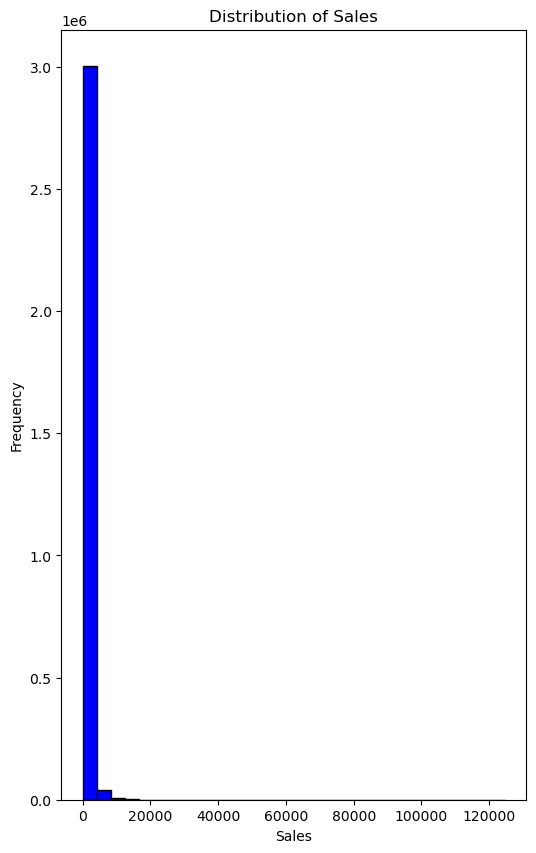

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting a histogram of the target variable 'sales'
plt.figure(figsize=(6, 10))
plt.hist(y, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Pair plot for visualization of relationships between features
data_for_visualization = pd.concat([y, X], axis=1)
sns.pairplot(data_for_visualization)
plt.show()